<a href="https://colab.research.google.com/github/3x10e8/telluride-21/blob/neurodyn/Designing_excitable_behaviors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [2]:
try:
    # check if running in google colab
    import google.colab
    
    # if in colab, clone the repo first
    ! git clone https://github.com/3x10e8/telluride-21.git
        
    # move into the repo directory for accessing other modules
    %cd telluride-21/
    
except ModuleNotFoundError:
    # we must be running locally
    try:
        # for formatting cells with black
        %load_ext blackcellmagic
        print("Can run %%black to format cells now!")
    except ModuleNotFoundError:
        pass # optional

Can run %%black to format cells now!


# Designing excitable behaviors

## Overview

This notebook provides a guide to designing spiking and bursting behaviors using the simplified neuronal model described in [Neuromodulation of Neuromorphic Circuits](https://arxiv.org/abs/1805.05696) and [Neuromorphic Control](https://arxiv.org/abs/2011.04441). The guide is intended as a general introduction to understanding how spiking and bursting behaviors are built through the interconnection of mixed feedback elements. The elements of this model have a simple form that enables easy synthesis and analysis procedures, but they emulate the same roles that different ionic currents provide in biophysical neurons. By the end of the guide, readers should have a good understanding of the essential elements required for generating a rich set of neuronal behaviors, as well as gain an intuition of what effect different ionic currents have in more complicated biophysical neuronal models.

**Note:**
When rerunning cells that use `add_conductance` or `add_current` methods, the elements will be added **in addition** to all of the elements added previously. If you would like to change parameters of an element that you have already added, either use element's `update` methods shown later in the notebook, or rerun all of the cells from the start so you start with an empty neuron. You can rerun the whole notebook up to a cell by clicking on the top:

`Cell -> Run All Above`

or just run the whole notebook from the start:

`Cell -> Run All`

## Defining a model

We first need to load the model definitions and the required Python packages:

- `matplotlib`: Python library for plotting
- `numpy`: Python library for numerical operations
- `iv_model`: definitions for constructing and simulating neurons

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from iv_model import Neuron

%matplotlib inline
%load_ext autoreload
%autoreload 2

We first start by creating a single neuron object of the Neuron class by executing:

In [4]:
neuron = Neuron(v0 = 0)

This line generates an *empty* neuron circuit, consisting only of a membrane capacitor with default capacitance $C = 1$ with the initial voltage set to $V_0 = 0$.

If we instead wish to set the membrane capacitance to say $C = 1\mu F$ and the initial voltage to $V = 5mV$, we can pass optional keyword arguments when creating the neuron:

`neuron = Neuron(C = 1e-6, v0 = 5e-3)`

For the purposes of this notebook, we will stick with the dimensionless variables to simplify the exposure, but the parameters of the model may be changed appropriately to generate spiking behavior in the biophysical range.

## Interconnecting elements

Fig. 1 shows a general representation of a neuron as a parallel interconnection of a passive membrane, consisting of the membrane capacitance and passive (leak) resistance, and a multitude of *feedback currents*, i.e. elements emulating the action of ionic currents.

<div>
<img src="https://github.com/3x10e8/telluride-21/blob/main/figures/neuromorphic_circuit.png?raw=1" width="500"/>
<caption><center> <b>Fig. 1: </b>Neural circuit as a parallel interconnection of elements </center></caption>
</div>

At the moment, our neuron consists solely of a membrane capacitor, so let's start forming the neuron by interconnecting elements in parallel one by one. We first add a single passive resistor with conductance $g_l = 1$ in series with a battery of voltage $E_l = 0$, mirroring the *leak* conductance element of the classical Hodgkin-Huxley model $I_{l} = g_l (V - E_l)$:

In [5]:
R = neuron.add_conductance(1, E_rev = 0)

The method `add_conductance` takes two arguments: the first defining the maximal conductance, and the second (optinal) argument defining the reversal potential. Ignoring the second argument sets $E_{rev} = 0$ so we didn't have to explicitly write it here.

In [6]:
# plotting utility functions to be called in cells below
def plot_IV(I, V, ax=[], ylim=[], append_title=''):
    
    if ax == []:
        fig, ax = plt.subplots()

    ax.set_title("I-V curve " + append_title)
    ax.set_xlabel("Voltage [a.u.]")
    ax.set_ylabel("Current [a.u.]")
    ax.plot(V, I, label='I-V')
    plt.legend()
    plt.grid(True)
    
    if ylim != []:
        ax.set_ylim(ylim)
        
    plt.show()


def plot_step_response(neuron_model, i_app):
    # matplotlib's blue color from stackexchange
    MY_DEFAULT_BLUE = (
        "#1f77b4"  # for coloring labels/axis using matplotlib's default blue
    )
    # Solve for the step response response
    sol = neuron_model.simulate(trange, i_app)  # call neuron's simulate functionality

    fig, axI = plt.subplots()
    axI.plot(sol.t, i_app(sol.t))
    axI.set_ylabel("Input current $I_{app}$ [a.u.]", color=MY_DEFAULT_BLUE)
    axI.tick_params(axis="y", labelcolor=MY_DEFAULT_BLUE)
    axI.set_xlabel("Time")

    axV = axI.twinx()
    axV.set_title("Passive membrane step response")
    axV.set_ylabel("Membrane voltage [a.u.]", color="r")
    axV.tick_params(axis="y", labelcolor="r")
    axV.plot(sol.t, sol.y[0], "r")
    plt.grid()
    plt.show()

### Steady-State Response
We can check that the neuron consists of a single resistor interconnected with the membrane capacitor by measuring its current-voltage (**IV**) curve. The method `IV_ss` sums up the steady-state IV curves of all elements in the circuit (note that at steady state the current going through the capacitor is $0$, so we can ignore it). Since so far we only have a single resistor element, the function should measure its IV characteristic.

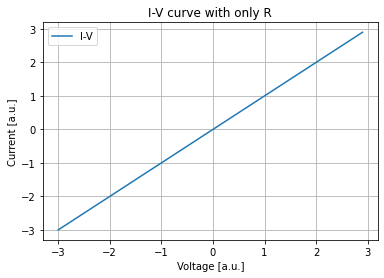

In [7]:
V = np.arange(-3, 3, 0.1)
I = neuron.IV_ss(V)
plot_IV(I, V, append_title='with only R')

The neuron's IV curve is a straight line - characteristic of a linear resistor!

The neuron is now a simple leaky integrator that integrates the applied current. Let us check its behavior by applying a step input current at $t = 5$:

### Simulated Step Response

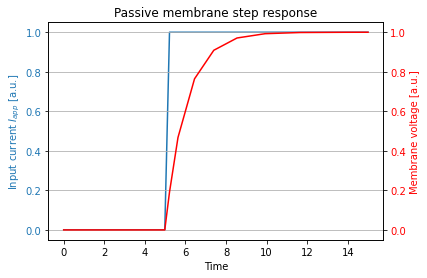

In [8]:
trange = (0, 15) # time length of simulation
i_app = lambda t: (t<5)*0 + (t>=5)*1 # Iapp(t)

sol = neuron.simulate(trange, i_app) # call neuron's simulate functionality

# Plot simulation
plot_step_response(neuron, i_app)

The neuron acts as a simple first-order filter: the voltage follows a step change in the applied current with a time lag given by the membrane capacitance and the conductance of the resistive element.

### Changing $E_{leak}$
What happens if we change the leak's reversal potential?

In [9]:
import ipywidgets

In [10]:
from matplotlib.lines import MarkerStyle

@ipywidgets.interact(E_rev_leak=(-3, 3))
def R_plot(E_rev_leak=0):  # this works on global variables neuron, R
    # update the leak resistance R's E_rev
    R.E_rev = E_rev_leak

    # plot E_rev
    fig, ax = plt.subplots()
    ax.axvline(x=E_rev_leak, c="r", alpha=0.5, label="$E_{rev}$")
    
    # also plot the steady state response
    I = neuron.IV_ss(V)
    plot_IV(I, V, ax, ylim=[-3, 3], append_title='with only R')

interactive(children=(IntSlider(value=0, description='E_rev_leak', max=3, min=-3), Output()), _dom_classes=('w…

## Active Elements

In order to build interesting dynamical behaviors, we need to interconnect *active* elements that emulate the dynamical properties of ionic currents. All active elements (voltage-controlled currents $I_j$ in Fig. 1) will have the same simplified form:

$$I_j = \alpha_j \tanh (V_j - V_{off,j})$$
$$\tau_j \dot{V}_j = V - V_j$$

The first-order filter defines the timescale of the element, so that increasing the parameter $\tau_j$ renders the element slower. The other two parameters are $\alpha_j$, defining the gain of the element, and $V_{off,j}$, defining the mid-point of the hyperbolic tangent function.

Importantly, we can also change the **sign** of $\alpha_j$:
- $\alpha_j > 0$ element has a purely **positive** resistance current-voltage characteristic
- $\alpha_j < 0$ element has a purely **negative** resistance current-voltage characteristic

## Designing a bistable neuron

Let's start by adding a single active element. Since with this element we would like to capture the fast excitatory nature of the activation of the sodium current, we can set it to be *instantaneous*, i.e. we can set $\tau_x = 0$. We would also like this element to have a *negative resistance* characteristic, so let's start by setting $\alpha = -1$. We will keep $V_{off}=0$ for now.

In [11]:
a = -1
voff = 0
tau = 0

i1 = neuron.add_current(a, voff, tau)

Let's first measure the element's current-voltage (IV) characteristic. We can do this by calling the element's `out` method that takes the input voltage and returns the output current:

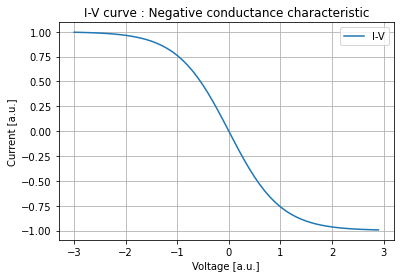

In [13]:
V = np.arange(-3, 3, 0.1)
I = i1.out(V)
plot_IV(I, V, append_title=': Negative conductance characteristic')

We can explore how varying these parameters changes the element's I-V curve:

In [14]:
@ipywidgets.interact(αNa=(-3, 3), voff_Na=(-3, 3), τNa=(-3,3))
def i1_plot(αNa=-1, voff_Na=0, τNa=0): # this works on global variables neuron, i1
  #print(dir(i1))
  i1.a = αNa
  i1.voff = voff_Na
  i1.tau = τNa # note: changing tau doesn't affect the steady state response
  I = i1.out(V)

  plot_IV(I, V, append_title=': Negative conductance characteristic')

interactive(children=(IntSlider(value=-1, description='αNa', max=3, min=-3), IntSlider(value=0, description='v…

Interconnection of the element should have changed the neuron's steady-state IV curve. Let's measure this now:

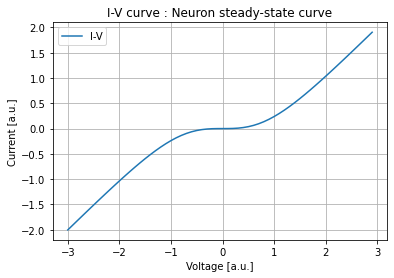

In [15]:
I = neuron.IV_ss(V)

plot_IV(I, V, append_title=': Neuron steady-state curve')

We observe that the steady-state characteristic has indeed changed - the addition of the negative resistor has decreased the slope around the origin (note that the slope is exactly $0$ at $V = 0$).

Let's now try varying the gain of the negative resistor in order to change IV characteristic: we wish to make the neuron **bistable** so that for some $I_{app}$ there are **two** stable equilibrium voltages. Let's change the gain of the element $\alpha$ so that for a range of voltages there is a *negative slope* in the IV characteristic, i.e. the IV characteristic should resemble a letter "N".

In [16]:
# change the value a = ..
# a = -2

@ipywidgets.interact(E_rev_L=(-3, 3), 
                     αNa=(-3, 3), voff_Na=(-3, 3), τNa=(-3,3))
def NaL_plot(E_rev_L=0, αNa=-2, voff_Na=0, τNa=0):

    # update parameters
    R.E_rev = E_rev_L
    i1.a = αNa
    # i1.update_a(a)
    i1.voff = voff_Na
    i1.tau = τNa # note: changing tau doesn't affect the steady state response

    I = neuron.IV_ss(V) # this is the composite response

    fig, ax = plt.subplots()
    
    # Also plot contributing currents from individual elements:
    I_L = R.out(V)
    ax.plot(V, I_L, 'r:', label='$I_{L}$')

    I_Na = i1.out(V)
    ax.plot(V, I_Na, 'g:', label='$I_{Na}$')
    
    plot_IV(I, V, ax, append_title=': Neuron steady-state IV curve')

interactive(children=(IntSlider(value=0, description='E_rev_L', max=3, min=-3), IntSlider(value=-2, descriptio…

If the IV characteristic has the "N-shape" the system will be bistable and we have created a *switch*: the circuit will remember its state even after the transient input is gone. Let us test this behavior by injecting a series of current pulses:

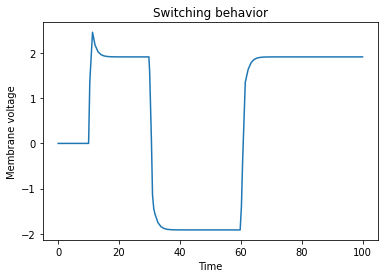

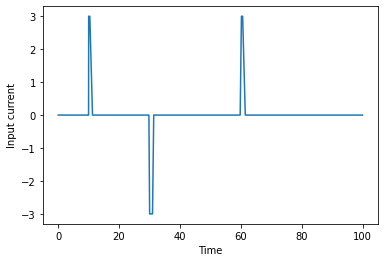

In [17]:
trange = (0, 100) # time length of simulation

def pulse(t, t_start, t_length, mag):
    I = (t>=t_start)*mag - (t>=(t_start+t_length))*mag
    return I

def i_app(t):
    p1 = pulse(t, 10, 1, 3)
    p2 = pulse(t, 30, 1, -3)
    p3 = pulse(t, 60, 1, 3)
    
    # More pulses can be added here
    pulses = [p1, p2, p3]
    I = 0
    for q in pulses:
        I = I + q
    return I

sol = neuron.simulate(trange, i_app, max_step=1) # need to set max_step so that the pulse is not *missed*

# Plot simulation
plt.figure()
plt.title("Switching behavior")
plt.xlabel("Time")
plt.ylabel("Membrane voltage")
plt.plot(sol.t, sol.y[0])

plt.figure()
plt.xlabel("Time")
plt.ylabel("Input current")
plt.plot(sol.t, i_app(sol.t))

plt.show()

We can play around with the pulse timings, magnitudes as well as lengths to see how they affect the switching behavior. If the negative resistance region is increased, the system has a larger energy barrier between the two stable states, so we may notice that we need to increase the pulse duration and/or magnitude in order to reliably switch the state.

## From bistable behavior to spiking

Having designed a neuron with two stable states we are now missing one more component to make the circuit spiking! This component needs to emulate the slow refractory nature of the activation of the potassium current. From the dynamical systems point of view, this current essentially needs to "automatically" adjust the applied current, so that when the voltage jumps to a "high" state, the slow current *decreases* the applied current and drives the neuron back to the rest.

We now introduce a slow element to our neuron in a similar way as before. Unlike the first element, this one needs to provide *positive resistance* and needs to be non-instantaneous. In order to make the element *slow*, a good rule of thumb is that the timescale needs to be at least $20$ times the membrane time-constant. Since the membrane time-constant is given by $\tau_{m} = (RC)_{mem}$ and we have previously set both $R = 1$ and $C = 1$, we need to set $\tau_s \geq 20$.

In [ ]:
ts = 20
voff = 0
a = 1

i2 = neuron.add_current(a, voff, ts)

Let's now measure again the steady-state IV curve of the neuron. We can change the gain of the element and see how it changes the steady-state IV curve. Let's set the gain of the element so that the steady-state characteristic is back to a straight line:

In [ ]:
a = 2 # set the gain
i2.update_a(a)

V = np.arange(-3, 3, 0.1)
I = neuron.IV_ss(V)

plt.figure()
plt.title("Neuron steady-state IV curve")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.plot(V, I)
plt.show()

The neuron's steady-state IV curve is again that of a positive resistor! But, importantly, the neuron does not act like a simple resistor anymore because of the *fast* nature of the negative resistor - in the fast timescale, the circuit is still a bistable switch. We can see this by plotting IV curves in *different* timescales. We define these IV curves as follows:

$$\mathcal{I}_x (V) = \sum{I_j(V)}, \quad for \ all \ \tau_j \leq \tau_x$$

This formula has a simple interpreation: if we want to plot the IV curve of the circuit in the timescale given by $\tau_x$, then we just need to sum up the steady-state characteristics of all elements acting in this timescale or *faster*.

To check the fast IV curve, we set the $\tau_f = 0$ and call the `IV` method:

In [ ]:
tf = 0 # set the timescale
V = np.arange(-3, 3, 0.1)
I = neuron.IV(V, tf)

plt.figure()
plt.title("Fast IV curve")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.plot(V, I)
plt.show()

We can also observe what happens when we change `tf` in the previous code. From the equation, we expect that the IV curve plot will only change if we set `tf` to be larger than the timescale of the slow element. In this case, we would get the same output as if we directly measured the steady-state IV curve through `IV_ss` method.

The combination of the N-shaped fast IV curve, and the monotonically increasing slow IV curve means that the neuron will be spiking for a certain range of input currents:

In [ ]:
trange = (0, 300) # time length of simulation
I0 = -0.7
i_app = lambda t: I0# Iapp(t)

sol = neuron.simulate(trange, i_app) # call neuron's simulate functionality

# Plot simulation
plt.figure()
plt.title("Spiking behavior")
plt.xlabel("Time")
plt.ylabel("Membrane voltage")
plt.plot(sol.t, sol.y[0])
plt.show()

We can play around with the value of $I_0$ to see how it affects the neuronal behavior. For a small enough input current, the neuron will stop spiking and be at rest. It is however still *excitable* and a short excitatory pulse can generate a spike. We can try different values of $I_0$ and pulse parameters to see when we get a spike at the output:

In [ ]:
trange = (0, 300) # time length of simulation

def pulse(t, t_start, t_length, mag):
    I = (t>=t_start)*mag - (t>=(t_start+t_length))*mag
    return I

def i_app(t):
    p1 = pulse(t, 150, 2, 0.3)
    
    pulses = [p1]
    I = -1
    for q in pulses:
        I = I + q
    return I

sol = neuron.simulate(trange, i_app, max_step=1) # need to set max_step so that the pulse is not *missed*

# Plot simulation
plt.figure()
plt.title("Spike output")
plt.xlabel("Time")
plt.ylabel("Membrane voltage")
plt.plot(sol.t, sol.y[0])

plt.figure()
plt.xlabel("Time")
plt.ylabel("Input current")
plt.plot(sol.t, i_app(sol.t))

plt.show()

## Creating rest-spike bistability

We have so far seen how a spiking neuron can be created through the interconnection of a fast negative resistance element, and a slow positive resistance element. These elements replicate the fast excitatory nature of the sodium current, as well as the slower refractory mechanisms of the potassium activation and sodium inactivation.

We will now see how introducing slower currents into the mix allows the neuron to modulate its spiking behavior so that it experiences more complex dynamical phenomena, such as bistability between resting and spiking, and bursting. These currents are usually dependent on calcium ions in biophyiscal neurons, and tend to act on timescales significantly slower than the processes controlling the excitability of the cell.

We start with designing rest-spike bistability as it is a precursor to designing bursting behavior, very much how creating a bistable switch was the first step to generating spike outputs.

Let us add another element to the circuit - this time it will be a slow *negative* resistance element! Importantly, this time we will need to change the $V_{off}$ parameter of the element to be non-zero, as the slower calcium-dependent currents activate in lower voltage ranges than the previously considered sodium and potassium currents.

In [ ]:
ts = 20
voff = -0.9
a = -1.5

i3 = neuron.add_current(a, voff, ts)

Let's see how the addition of this element has changed the steady-state IV curve - remember, as the element is slow, it will not affect the fast IV curve, which we also plot for reference. You can change the element's gain and offset values to shape the steady-state IV curve.

In [ ]:
# Change the gain and the offset of the slow negative resistance element
#i3.update_a(-1.5)
#i3.update_voff(-0.9)

tf = 0 # set the timescale
V = np.arange(-3, 3, 0.1)
If = neuron.IV(V, tf)

Iss = neuron.IV_ss(V)

plt.figure()
plt.title("Fast IV curve")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.plot(V, If)
plt.show()

plt.figure()
plt.title("Steady-state IV curve")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.plot(V, Iss)
plt.show()

Previously, when we had an "N-shaped" steady-state IV curve the neuron was bistable, and we were able to switch between the high "up" state and the low "down" state by injecting a series of current pulses.

We now have the same picture, but with an important difference - the high "up" state now belongs to the negative resistance region of the fast IV curve, i.e. the high "up" state is now a spiking state!

Let's test this behavior by again injecting a series of pulses and switching the system between the resting and spiking states. This time we will need to use longer pulses, as the circuit operates on the *slow* timescale, compared to the *fast* timescale of our simple bistable neuron.

In [ ]:
trange = (0, 3000) # time length of simulation

def pulse(t, t_start, t_length, mag):
    I = (t>=t_start)*mag - (t>=(t_start+t_length))*mag
    return I

def i_app(t):
    p1 = pulse(t, 800, 20, -1)
    p2 = pulse(t, 1600, 20, 1)
    p3 = pulse(t, 2400, 20, -1)
    
    # add more pulses
    pulses = [p1, p2, p3]
    I = -0.8 # this current needs to be in the *bistable* region
    for q in pulses:
        I = I + q
    return I

sol = neuron.simulate(trange, i_app, max_step=1) # need to set max_step so that the pulse is not *missed*

# Plot simulation
plt.figure()
plt.title("Switching behavior")
plt.xlabel("Time")
plt.ylabel("Membrane voltage")
plt.plot(sol.t, sol.y[0])

plt.figure()
plt.xlabel("Time")
plt.ylabel("Input current")
plt.plot(sol.t, i_app(sol.t))

plt.show()

We can play around with the gain and offset parameters of the slow negative resistance element and see how it affects the steady-state IV curve and correspondingly the switching behavior.

## Bursting

We will now turn the rest-spike bistable neuron into a burster. We can achieve this again by following the same procedure as when going from a bistable to a spiking neuron: we need to introduce a slower current that will "automatically" modulate the current so that when neuron is in the resting state, the current increases and leads to spiking, and when the neuron is in the spiking state, the current decreases and terminates the burst.

We will call the timescale of this element *ultra-slow* as it needs to be significantly slower than the processes introduced so far. Let's define this element now:

In [ ]:
tus = ts**2
voff = -0.9
a = 1.5

i4 = neuron.add_current(a, voff, tus)

Let's measure the neuron's IV curves again. This time, there will be three IV curves of interest: fast, slow, and the steady-state (ultra-slow) IV curve.

In [ ]:
tf = 0 # set the timescale
ts = 20

V = np.arange(-3, 3, 0.1)

If = neuron.IV(V, tf)
Is = neuron.IV(V, ts)
Iss = neuron.IV_ss(V)

plt.figure()
plt.title("Fast IV curve")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.plot(V, If)
plt.show()

plt.figure()
plt.title("Slow IV curve")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.plot(V, Is)
plt.show()

plt.figure()
plt.title("Steady-state IV curve")
plt.xlabel("Voltage")
plt.ylabel("Current")
plt.plot(V, Iss)
plt.show()

When the input current is in the right range, the neuron will now burst!

In [ ]:
trange = (0, 2000) # time length of simulation
I0 = -1
i_app = lambda t: I0# Iapp(t)

sol = neuron.simulate(trange, i_app) # call neuron's simulate functionality

# Plot simulation
plt.figure()
plt.title("Bursting behavior")
plt.xlabel("Time")
plt.ylabel("Membrane voltage")
plt.plot(sol.t, sol.y[0])
plt.show()

We can again try changing the applied current $I_0$ to observe the different spiking regimes of the neuron. You should notice that for low currents the neuron is at rest, but above a certain threshold the neuron starts bursting. Increasing the current further eventually terminates the bursts and leads to regular spiking, before again reaching a high resting state for a large enough input current.

## Graphical interface with live plotting

If you would like to explore further how changing the parameters modulates the behavior with a live neuron simulation, there is additional code that can be found at the following GitHub page [Circuit-Neuromodulation](https://github.com/lukaribar/Circuit-Neuromodulation).

The script `gui.py` genereates a graphical interface for controlling the gain and offset values for the elements discussed here, and you can observe the different behaviors that can be achieved by exploring the different parameter combinations. Mainly, you should observe how changing each parameter affects the IV curves of the circuit, which in turn capture the main excitability properties of the circuit.